[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/036_rnn_mejoras/rnn_mejoras.ipynb)

# Laboratorio 4. Redes Neuronales Recurrentes
Predicción de la calidad del agua, a lo largo de todo el año 2024 y 2025.

## 1. Generación de un dataset sintético para predecir el "Cianuro libre" en el agua

In [ ]:
import numpy as np

# Función para generar la serie temporal con valores de Cianuro Libre
def generate_time_series_cianuro(batch_size, n_steps):
    # Generamos las series basadas en funciones seno con valores aleatorios
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)

    # Generamos la primera ola (wave 1) y segunda ola (wave 2)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2

    # Añadimos ruido a la serie
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise

    # Escalamos los valores para que estén dentro del rango de Cianuro Libre (0.001 a 0.300)
    series = (series - series.min()) / (series.max() - series.min())            # Normalizamos entre 0 y 1

    series = series * 0.299 + 0.001  # Ajustamos al rango 0.001 a 0.300

    return series[..., np.newaxis].astype(np.float32)

# DEFINIR PARÁMETROS DEL DATASET
n_steps = 50  # Número de pasos de tiempo
batch_size = 10000  # Tamaño del conjunto de datos

# GENERAR SERIES TEMPORALES PARA EL PARÁMETRO 'Cianuro Libre'
series = generate_time_series_cianuro(batch_size, n_steps + 10)                 # 1) VER ABAJO DESCRIPCIÓN

# SEPARAR LOS DATOS EN CONJUNTO DE ENTRENAMIENTO, VALIDACIÓN Y PRUEBA
X_train = series[:7000, :n_steps]  # Primeras 7000 muestras para entrenamiento
X_valid = series[7000:9000, :n_steps]  # Muestras 7000 a 9000 para validación
X_test = series[9000:, :n_steps]  # Últimas 1000 muestras para prueba

# CREAR LAS ETIQUETAS 'Y' PARA PREDICCIONES A 10 PASOS ADELANTE                 # 2) VER ABAJO DESCRIPCIÓN
Y = np.empty((batch_size, n_steps, 10), dtype=np.float32)
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]

# Separar las etiquetas para entrenamiento, validación y prueba
Y_train = Y[:7000]  # Primeras 7000 muestras para entrenamiento
Y_valid = Y[7000:9000]  # Muestras 7000 a 9000 para validación
Y_test = Y[9000:]  # Últimas 1000 muestras para prueba

# Imprimir las formas de los datos para confirmar
print("X_train.shape:", X_train.shape)  # Debería ser (7000, 50, 1)
print("Y_train.shape:", Y_train.shape)  # Debería ser (7000, 50, 10)
print("X_valid.shape:", X_valid.shape)  # Debería ser (2000, 50, 1)
print("Y_valid.shape:", Y_valid.shape)  # Debería ser (2000, 50, 10)
print("X_test.shape:", X_test.shape)    # Debería ser (1000, 50, 1)
print("Y_test.shape:", Y_test.shape)    # Debería ser (1000, 50, 10)


X_train.shape: (7000, 50, 1)
Y_train.shape: (7000, 50, 10)
X_valid.shape: (2000, 50, 1)
Y_valid.shape: (2000, 50, 10)
X_test.shape: (1000, 50, 1)
Y_test.shape: (1000, 50, 10)


### Descripción de la generación de series temporales:
1) series = generate_time_series(10000, n_steps + 10)

ESTE DATASET CONTIENE 10,000 series, cada una con 60 pasos de tiempo (n_steps + 10). Los primeros 50 pasos de tiempo se utilizan como entradas (X_train, X_valid, X_test), y los siguientes 10 pasos se utilizan para los valores que queremos predecir (el objetivo).\
2) Para generar las etiquetas o los valores reales (Y) que corresponden a las predicciones, se usa este código:\
Y = np.empty((10000, n_steps, 10), dtype=np.float32)\
for step_ahead in range(1, 10 + 1):\
     Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]

BUCLE: toma los valores desde el paso 1 hasta el paso 10 (futuro) para cada serie temporal y los guarda en Y.

DE ESTA MANERA: Los valores reales (y) que se muestran en el gráfico son los pasos de tiempo futuros que el modelo intenta predecir. Se toman de Y_train, Y_valid o Y_test dependiendo de si estás trabajando con el conjunto de entrenamiento, validación o test.

Los valores de entrada (series) que se grafican provienen del dataset original series generado por generate_time_series(). Son los primeros 50 pasos de cada serie que se usan como entrada para entrenar el modelo recurrente.

RESUMEN: Los valores reales (las etiquetas) provienen del mismo dataset sintético, pero corresponden a los pasos futuros de las series que se utilizan para comparar con las predicciones del modelo.

## Imprimir las primeras 5 series temporales completas

In [ ]:
# Imprime las primeras 5 series temporales completas
print(series[:3])

[[[0.06053761]
  [0.10433818]
  [0.12433399]
  [0.17052487]
  [0.18312848]
  [0.21704425]
  [0.23126815]
  [0.24494365]
  [0.24391884]
  [0.24067175]
  [0.23905666]
  [0.22396815]
  [0.19858037]
  [0.18697624]
  [0.17044057]
  [0.15493396]
  [0.13334212]
  [0.1170607 ]
  [0.11594722]
  [0.0952758 ]
  [0.10048211]
  [0.10162843]
  [0.09188577]
  [0.09463664]
  [0.0983145 ]
  [0.0866047 ]
  [0.09637312]
  [0.11587162]
  [0.10930861]
  [0.12095323]
  [0.13868542]
  [0.17191912]
  [0.18305692]
  [0.20716828]
  [0.21647711]
  [0.24930419]
  [0.24100503]
  [0.25656128]
  [0.23993668]
  [0.23732165]
  [0.21101037]
  [0.19695446]
  [0.15119824]
  [0.12448974]
  [0.09773166]
  [0.06234074]
  [0.04135564]
  [0.01325667]
  [0.01411361]
  [0.01802995]
  [0.0277633 ]
  [0.05221126]
  [0.10289687]
  [0.12861724]
  [0.16576259]
  [0.2006283 ]
  [0.24386202]
  [0.2730878 ]
  [0.2888473 ]
  [0.28090352]]

 [[0.2066721 ]
  [0.17694181]
  [0.13385221]
  [0.11326901]
  [0.11410156]
  [0.11252962]
  [0.102

## Imprimir las dimensiones del array para verificar su estructura

In [ ]:
print(series.shape)  # Esto imprime (10000, 60, 1), que son los ejemplos, pasos de tiempo y características

(10000, 60, 1)


## Unidad de tiempo en las series temporales generadas
La unidad de tiempo en las series temporales generadas (o en cualquier modelo de predicción basado en series temporales) DEPENDE DEL CONTEXTO DEL PROBLEMA que estás tratando de resolver. En el código, no se especifica una unidad de tiempo específica como días, meses, o años. Esto se debe a que es un conjunto de datos sintéticos, y las unidades de tiempo no se definen explícitamente.

EN ESTE CASO:

Los 10 valores futuros que se predicen se refieren a los siguientes 10 pasos en la secuencia temporal. La naturaleza de esos pasos (días, meses, años, horas, minutos, etc.) dependerá de cómo se interprete o adapte el modelo a tu caso real.

POR EJEMPLO:

Si los datos representan mediciones diarias de la calidad del agua, entonces los 10 valores futuros pueden referirse a predicciones para los próximos 10 días.

Si los datos son mediciones mensuales, entonces serían predicciones para los próximos 10 meses.

-En resumen, en el modelo que estás usando, los "pasos de tiempo" son abstractos, y debes definir la unidad temporal según el contexto de tus datos reales.

## 2. Gráfico de series temporales

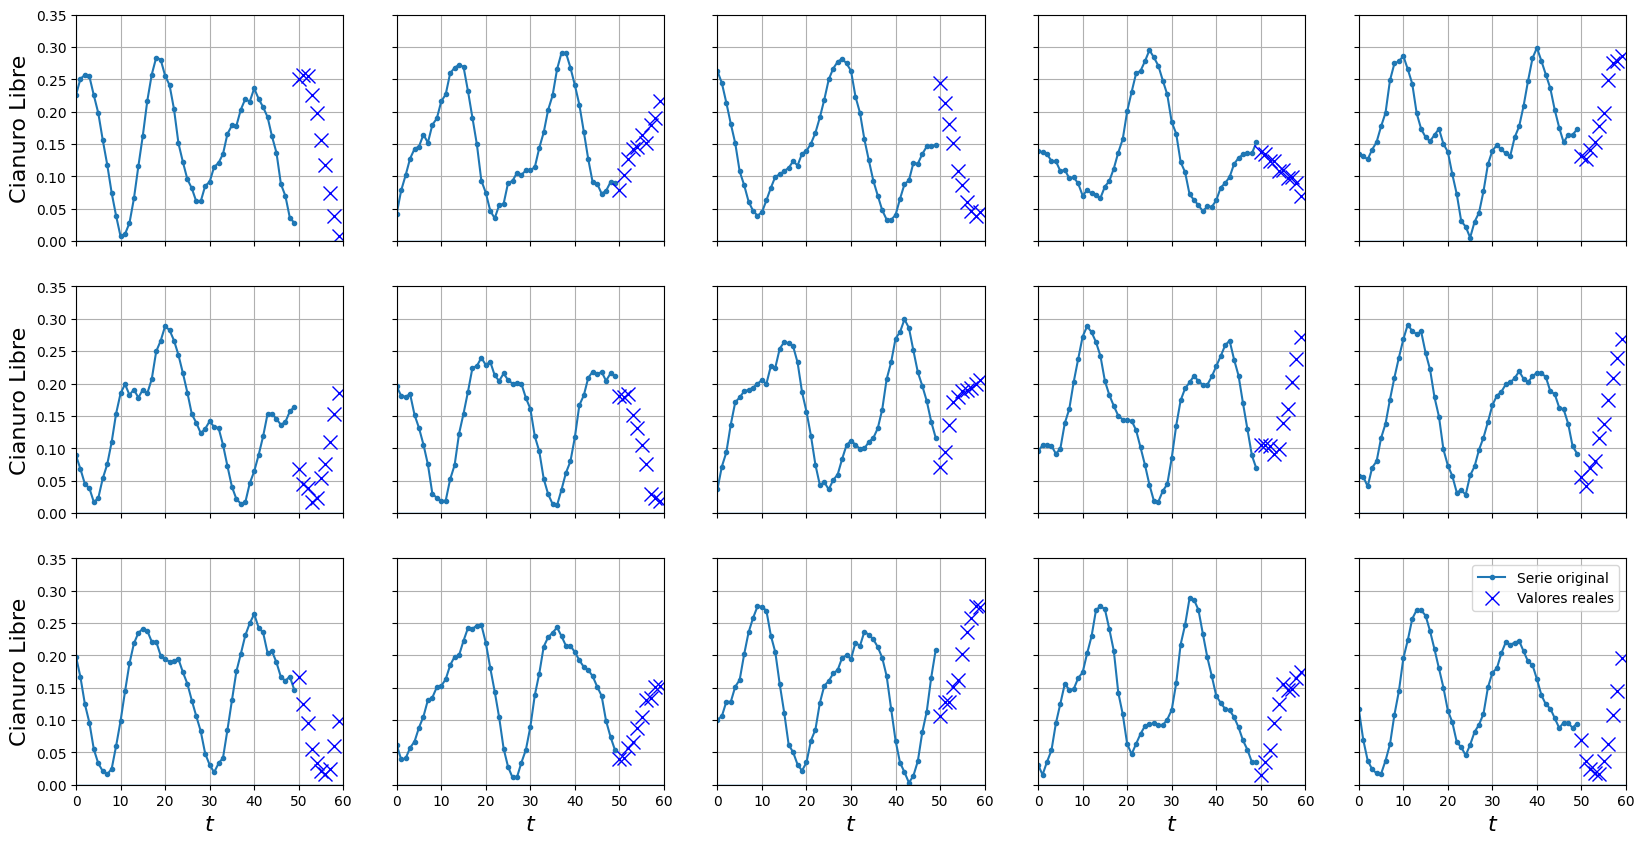

In [ ]:
import matplotlib.pyplot as plt

# Función para graficar series temporales, valores reales y predicciones
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="Cianuro Libre"):

    r, c = 3, 5  # Número de filas y columnas en el gráfico                                   # SE MUESTRAN 15 GRÁFICOS

    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))    # TAMAÑO DE LA FIGURA EN PULG (ancho, alto)

    for row in range(r):
        for col in range(c):
            plt.sca(axes[row][col])
            ix = col + row*c            # Índice del gráfico actual

            # Graficar la serie temporal original
            plt.plot(series[ix, :], ".-", label="Serie original")

            # Graficar los valores reales (y)
            if y is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10, label="Valores reales")

            # Graficar las predicciones (y_pred)
            if y_pred is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro", label="Predicción")

            # Graficar la desviación estándar (si aplica)
            if y_pred_std is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix], "r--")
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix], "r--")

            plt.grid(True)  # Mostrar cuadrícula
            plt.hlines(0, 0, n_steps + 10, linewidth=1)           # Línea horizontal en y=0
            plt.axis([0, n_steps + 10, 0, 0.35])                  # Define los Límites de los ejes (ajustados al rango de Cianuro Libre)

            # Etiquetas de los ejes
            if x_label and row == r - 1:
                plt.xlabel(x_label, fontsize=16)
            if y_label and col == 0:
                plt.ylabel(y_label, fontsize=16, rotation=90)

    plt.legend(loc="upper right")  # Mostrar la leyenda
    plt.show()

# Supongamos que tienes las series de entrenamiento y las predicciones
# Ejemplo de uso de la función con los datos generados
plot_series(X_train[:15, :, 0], y=Y_train[:15, 0, :], y_pred=None)  # Graficar las primeras 15 series


Los 15 gráficos se eligen secuencialmente de la matriz series, que contiene todas las series generadas o calculadas.\
ix = col + row * c  -> Significa que el gráfico en la columna col y la fila row se obtiene tomando el índice ix, que corresponde a la serie en la posición específica dentro de series. Este índice se incrementa de manera secuencial a medida que se recorren las filas y columnas de la cuadrícula de gráficos.

Ejemplo en la primera fila: Los gráficos corresponden a los índices 0, 1, 2, 3, 4 (ya que row = 0 y col varía de 0 a 4).

## 3. Creación de los Dataloaders

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Definimos el dataset para las series temporales
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y=None, train=True):
        # X: los datos de entrada (las series temporales)
        # y: los valores futuros (predicciones que el modelo intenta hacer)
        self.X = X
        self.y = y
        self.train = train

    def __len__(self):
        # Retorna el número total de ejemplos en el dataset
        return len(self.X)

    def __getitem__(self, ix):
        # Si estamos en modo de entrenamiento/validación, retornamos tanto las entradas (X) como las etiquetas (y)
        if self.train:
            return torch.from_numpy(self.X[ix]).float(), torch.from_numpy(self.y[ix]).float()
        # Si estamos en modo de test, retornamos solo las entradas (X)
        return torch.from_numpy(self.X[ix]).float()

# Creamos los datasets para entrenamiento, validación y prueba
dataset = {
    'train': TimeSeriesDataset(X_train, Y_train),
    'eval': TimeSeriesDataset(X_valid, Y_valid),
    'test': TimeSeriesDataset(X_test, Y_test, train=False)
}

# Creamos los DataLoaders para cargar los datos en lotes
dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),  # Barajamos los datos para entrenamiento
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),   # No barajamos los datos para validación y test
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

# Verificamos las dimensiones de los primeros datos cargados por el DataLoader        # VER DESCRIPCIÓN ABAJO
for X_batch, Y_batch in dataloader['train']:
    print(X_batch.shape, Y_batch.shape)  # Esto debería imprimir (batch_size, n_steps, 1) y (batch_size, n_steps, 10)
    break


torch.Size([64, 50, 1]) torch.Size([64, 50, 10])


DESCRICIÓN:\
1) Dimensiones de X (Entradas): (batch_size, n_steps, 1)

Si batch_size = 64 y n_steps = 50, entonces las dimensiones de X serían (64, 50, 1).
Esto significa que tienes 64 series temporales en un solo lote, cada una con 50 pasos de tiempo, y cada paso de tiempo tiene un valor de concentración de cianuro.\
2) Dimensiones de Y (Etiquetas o valores esperados): (batch_size, n_steps, 10)

Si batch_size = 64, n_steps = 50, y estás prediciendo los próximos 10 valores, entonces las dimensiones de Y serían (64, 50, 10).
Esto significa que, para cada uno de los 64 ejemplos, la red tratará de predecir 10 valores futuros para cada paso de tiempo de la serie de entrada.

## 4. Función de entrenamiento

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

# Dispositivo: usa GPU si está disponible, de lo contrario CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Función de entrenamiento (adaptada para el parámetro Cianuro Libre)
def fit(model, dataloader, epochs=10):

    model.to(device)  # Mueve el modelo al dispositivo (GPU o CPU)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Optimizador Adam con tasa de aprendizaje de 0.001

    criterion = torch.nn.MSELoss()  # Función de pérdida MSE (Error Cuadrático Medio)

    bar = tqdm(range(1, epochs+1))  # Barra de progreso para monitorear el entrenamiento

    for epoch in bar:  # Ciclo de entrenamiento para cada época

        model.train()  # Modo de entrenamiento
        train_loss = []  # Lista para almacenar la pérdida en el conjunto de entrenamiento
        train_loss2 = []  # Lista para la pérdida del último paso

        for batch in dataloader['train']:  # Itera sobre los lotes de datos de entrenamiento
            X, y = batch                    # Obtiene X (entrada) y y (etiqueta o salida esperada)
            X, y = X.to(device), y.to(device)   # Mueve los datos al dispositivo
            optimizer.zero_grad()                # Resetea los gradientes
            y_hat = model(X)                    # Predicciones del modelo
            loss = criterion(y_hat, y)          # Calcula la pérdida (error)
            loss.backward()                     # Retropropaga el error
            optimizer.step()  # Actualiza los pesos del modelo
            train_loss.append(loss.item())  # Almacena la pérdida en el entrenamiento

            # Calcula la pérdida del último paso de predicción
            train_loss2.append((y[:, -1] - y_hat[:, -1]).pow(2).mean().item())

        model.eval()  # Modo de evaluación (desactiva el cálculo de gradientes)
        eval_loss = []  # Lista para la pérdida en validación
        eval_loss2 = []  # Lista para la pérdida del último paso en validación

        with torch.no_grad():  # No calcula gradientes en modo evaluación
            for batch in dataloader['eval']:  # Itera sobre los lotes de datos de validación
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                eval_loss2.append((y[:, -1] - y_hat[:, -1]).pow(2).mean().item())

        # Actualiza la barra de progreso con las pérdidas
        bar.set_description(f"loss {np.mean(train_loss):.5f} loss_last_step {np.mean(train_loss2):.5f} "
                            f"val_loss {np.mean(eval_loss):.5f} val_loss_last_step {np.mean(eval_loss2):.5f}")

# Función para hacer predicciones
def predict(model, dataloader):

    model.eval()  # Modo de evaluación

    with torch.no_grad():  # No calcular gradientes
        preds = torch.tensor([]).to(device)  # Tensor vacío para almacenar predicciones
        for batch in dataloader:  # Itera sobre los lotes de datos de test
            X = batch  # Solo la entrada (sin etiquetas, ya que es test)
            X = X.to(device)  # Mueve al dispositivo
            pred = model(X)  # Predicciones
            preds = torch.cat([preds, pred])  # Concatenar las predicciones
        return preds  # Devuelve las predicciones


## 5. PRIMERA PREDICCIÓN CON: La celda recurrente para predecir 10 valores

In [ ]:
import torch
import torch.nn as nn

# Clase para la Red Neuronal Recurrente (RNN) profunda
class DeepRNN(nn.Module):

    def __init__(self, n_out=10):  # n_out es el número de pasos futuros a predecir (10 en este caso)
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)  # RNN con 2 capas y 20 unidades ocultas
        self.fc = nn.Linear(20, n_out)  # Capa totalmente conectada para predecir 10 valores a futuro

    def forward(self, x):
        x, h = self.rnn(x)  # Pasa la entrada a través de la RNN
        # Optimiza la red en todos los pasos, no solo en el último
        x_reshaped = x.contiguous().view(-1, x.size(-1))  # [Batch, time_steps, features] -> [Batch x time_steps, features]
        y = self.fc(x_reshaped)  # Pasa la salida de la RNN por la capa totalmente conectada
        y = y.contiguous().view(x.size(0), -1, y.size(-1))  # [Batch x time_steps, features] -> [Batch, time_steps, features]
        return y

In [ ]:
# Instanciar el modelo RNN
rnn = DeepRNN()

# Entrenar el modelo usando la función fit previamente definida
fit(rnn, dataloader)

loss 0.00188 loss_last_step 0.00146 val_loss 0.00187 val_loss_last_step 0.00143: 100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


## Realizar predicciones y graficar

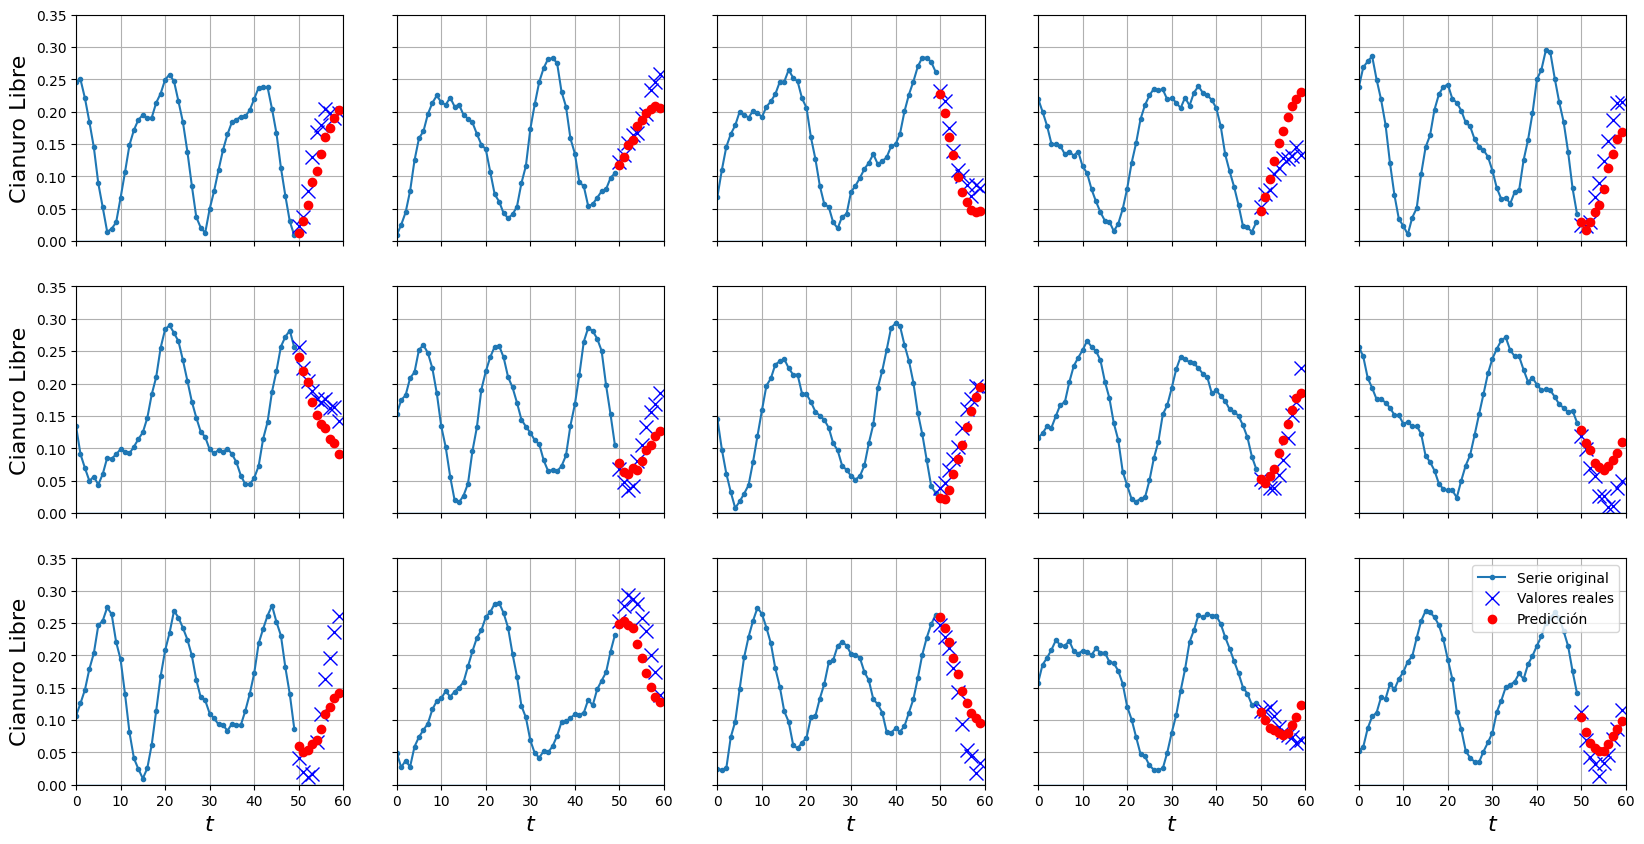

Mean Squared Error (MSE) en el último paso: 0.0014218955766409636


In [ ]:
from sklearn.metrics import mean_squared_error

# Predecir valores usando el modelo entrenado sobre el conjunto de prueba
y_pred = predict(rnn, dataloader['test'])

# Graficar la serie temporal original y las predicciones
# En X_test tenemos la secuencia original, Y_test son los valores reales futuros, y y_pred las predicciones.
plot_series(X_test, Y_test[:,-1], y_pred[:,-1].cpu().numpy())

# Evaluar el error cuadrático medio (MSE) para las predicciones en los últimos valores
mse = mean_squared_error(Y_test[:,-1], y_pred[:,-1].cpu())
print(f"Mean Squared Error (MSE) en el último paso: {mse}")

ÉSTOS RESULTADOS LOS OBTUVIMOS CON LA CAPA torch.nn:\
-EN ÉSTE CASO FUNCIONA PORQUE NO SON SERIES TEMPORALES LARGAS, TENEMOS 50 VALORES.\
-NORMALMENTE NO SE TRABAJA CON LA LAS REDES torch.nn SINO CON OTRAS.\
LA RAZÓN ES PORQUE ÉSTA IMPLEMENTACIÓN DE RED NEURONAL RECURRENTE SENCILLA TIENE PROBLEMAS A LA HORA DE TRABAJAR CON SECUENCIAS LARGAS.

-EXPLODING GRADIENT -> SI LOS PESOS SON MUY GRANDES LOS GRADIENTES VAN A IR CRECIENDO Y CRECIENDO Y VA A SER IMPOSIBLE ENTRENAR PORQUE VAN A EXPLOTAR.\
-ALTERNATIVA QUE LOS PESOS SEAN PEQUEÑOS. VANISHING GRADIENTS -> LOS GRADIENTES SE VAN IR HACIENDO CADA VEZ MÁS PEQUEÑOS. LOS GRADIENTES ACABAN DESAPARECIENDO DE FORMA DE QUE SI LAS SECUENCIAS SON MUY LARGAS, LA INFLUENCIA QUE TIENEN LOS PRMEROS INPUTS SOBRE LOS ÚLTIMOS OUTPUTS ES NULA PORQUE LOS GRADIENTES HAN DESAPARECIDO.\
-POR ESO EN LA PRÁCTICA, LAS CELDAS RECURRENTES SENCILLAS NO SE UTILIZAN CUANDO TRABAJAMOS CON SECUENCIAS LARGAS PORQUE NO SE PUEDEN ENTRENAR.\
-SOLUCIÓN: CAMBIAR ÉSTA CELDA Y UTILIZAR OTRA -> LA CELDA RECURRENTE LSTM.

## 6. SEGUNDA PREDICCIÓN CON  *Long Short-Term Memmory* (LSTM)

In [ ]:
class LSTM(DeepRNN):                                                            # 1. IMPLEMENTACIÓN. RED LSTM HEREDA DE LA RED NEURONAL RECURRENTE QUE HENMOS HECHO ANTES

  def __init__(self, n_out=10, dropout=0):
    super().__init__()
    self.rnn = torch.nn.LSTM(input_size=1, hidden_size=20, num_layers=2, dropout=dropout, batch_first=True)   # SOBREESCRIBIMOS LA CAPA torch.nn.LSTM() -> AHORA LA RED FUNCIONA CON LAS CELDAS
                                                                                                              # LSTM EN VEZ DE LAS CELDAS SIMPLES QUE PUEDEN TENER LIMITACIONES.
                                                                                                              # EL RESTO DE PARÁMETROS SON EXACTAMENTE LOS  MISMOS
lstm = LSTM()

### PESOS QUE TENEMOS DENTRO DE LA CAPA NEURONAL:
-INPUTS QUE CONECTAN CON LA CAPA OCULTA: weight_ih = 80, AHORA TENEMOS UNA MATRIZ CON 80 PESOS. POR QUE 80? SI LE HEMOS PUESTO 20 NEURONAS EN LA CAPA OCULTA? AHORA TENEMOS ÉSTAS GATES Y CADA GATE TIENE SU PROPIO CONJUNTO DE PESOS. TENEMOS LOS PESOS DEL INPUT GATE, DEL FORGET GATE, DEL OUTPUT GATE Y LOS PESOS NOTRMALES QUE YA UTILIZÁBAMOS EN LA CELDA ANTERIOR -> EN LA RECURRENTE SIMPLE.

In [ ]:
# parámetros en inputs (W_ii|W_if|W_ig|W_io)            # TENEMOS 4 PUERTAS
# 4 matrices, 1 para cada *gate*

lstm.rnn.weight_ih_l0.shape, lstm.rnn.bias_ih_l0.shape

(torch.Size([80, 1]), torch.Size([80]))

In [ ]:
# parámetros en capa oculta (W_ii|W_if|W_ig|W_io)
# 4 matrices, 1 para cada *gate*

lstm.rnn.weight_hh_l0.shape, lstm.rnn.bias_hh_l0.shape

(torch.Size([80, 20]), torch.Size([80]))

In [ ]:
# salida y capas ocultas (short term y long term)

output, (h, c) = lstm.rnn(torch.randn(10, 50, 1))

# dims -> [num_layers, batch_size, len_seq]
h.shape, c.shape

(torch.Size([2, 10, 20]), torch.Size([2, 10, 20]))

### Entrenamiento
PODEMOS ENTRENAR ÉSTA LSTM CON EL  MISMO CÓDIGO DE ANTES.\
-VEREMOS QUE LAS MÉTRICAS (0.0120748) Y PREDICCIONES MEJORAN BASTANTE.\
-LA LSTM ESTÁ FUNCIONANDO MEJOR NO PORQUE LAS SECUENCIAS SEAN MUY LARGAS SINO PORQUE ES CAPAZ DE APROVECHAR MUCHO MEJOR LA INFORMACIÓN QUE TIENE.
-SI TRABAJÁRAMOS CON SERIES TEMPORALES MUY LARGAS DE 100, 500 VALORES SE VERÍA QUE LA LSTM FUNCIONA MUCHO MEJOR. LAS rnn NORMALES NI SIQUIERA LAS PODRÍAMOS ENTRENAR POR LOS GRADIENTES QUE SE VAN A CERO O EXPLOTAN.

In [ ]:
lstm = LSTM()
fit(lstm, dataloader)

loss 0.00171 loss_last_step 0.00106 val_loss 0.00169 val_loss_last_step 0.00102: 100%|██████████| 10/10 [00:32<00:00,  3.26s/it]


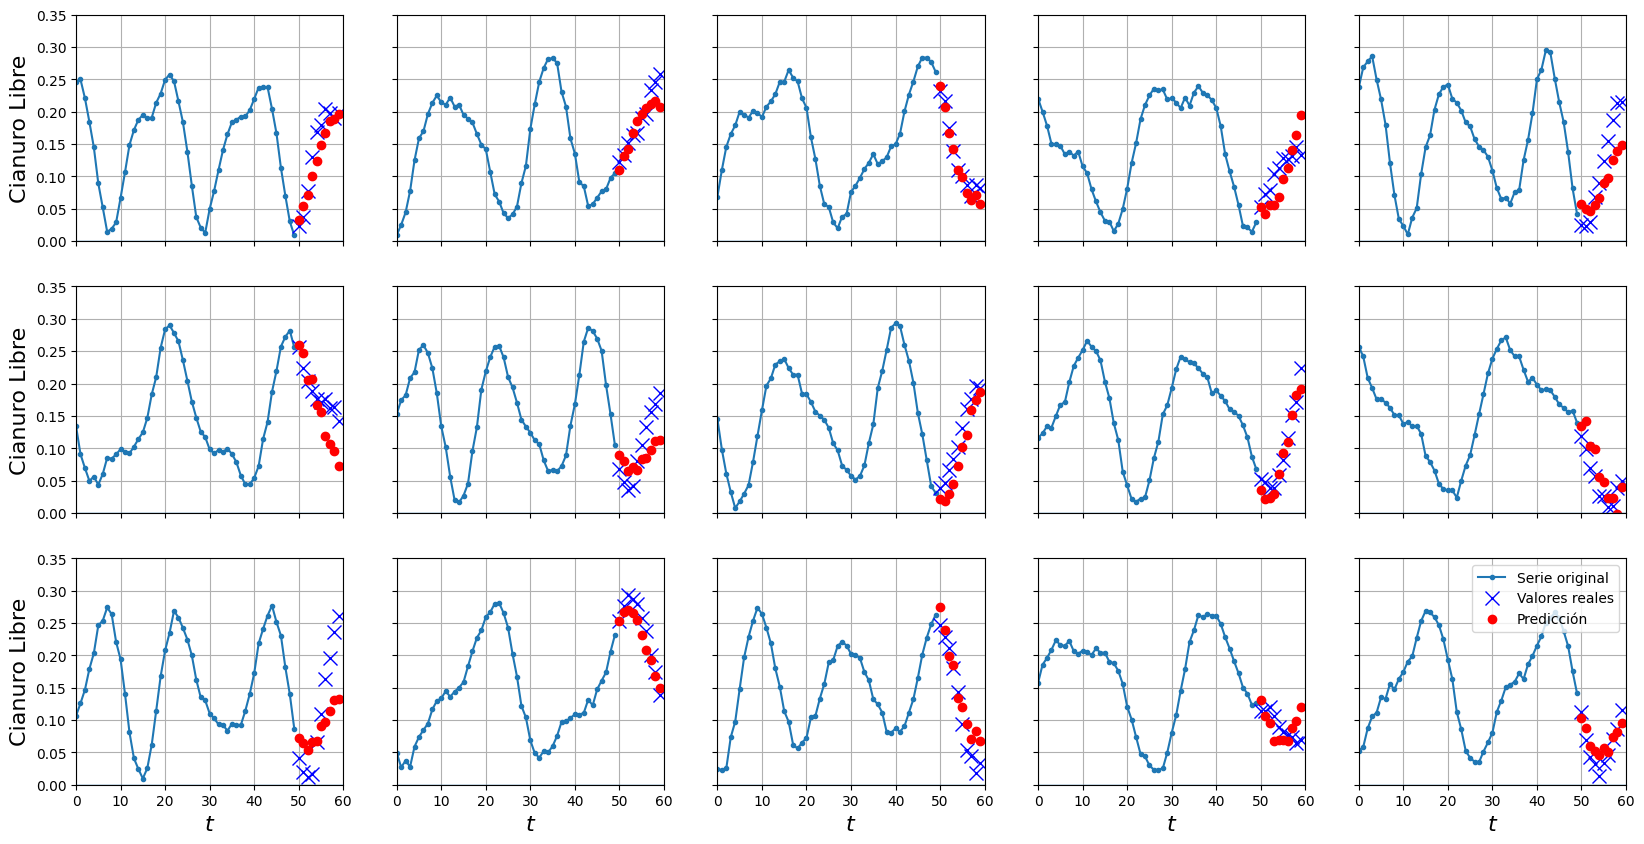

Mean Squared Error (MSE) para el modelo LSTM: 0.0010437603341415524


In [ ]:
# Realizar predicciones con el modelo LSTM entrenado sobre los datos de prueba
y_pred_lstm = predict(lstm, dataloader['test'])

# Graficar la serie temporal real y las predicciones generadas por LSTM
plot_series(X_test, Y_test[:,-1], y_pred_lstm[:,-1].cpu().numpy())

# Calcular el error cuadrático medio (MSE) para las predicciones
mse_lstm = mean_squared_error(Y_test[:,-1], y_pred_lstm[:,-1].cpu())
print(f"Mean Squared Error (MSE) para el modelo LSTM: {mse_lstm}")

## 7. TERCERA PREDICCIÓN CON Gated Recurrent Unit (GRU)

ES UN POCO UNA MEZCLA ENTRE LA SIMPLE Y LA LSTM, SOLO TENEMOS UN CAMINO LA 'h' YA NO TENEMOS LA 'c'.

In [ ]:
class GRU(DeepRNN):
    def __init__(self, n_out=10, dropout=0):
        super().__init__()

        # Sobreescribimos la capa RNN con GRU
        self.rnn = torch.nn.GRU(input_size=1, hidden_size=20, num_layers=2, dropout=dropout, batch_first=True)

        # El resto de la arquitectura se mantiene igual (capa fully connected para salida)

# Crear una instancia del modelo GRU
gru = GRU()

In [ ]:
# parámetros en inputs (W_ir|W_iz|W_in)                                         # TENEMOS SÓLO 3 PUERTAS EN VEZ DE 4
# 3 matrices, 1 para cada *gate*

gru.rnn.weight_ih_l0.shape, lstm.rnn.bias_ih_l0.shape                           # TENEMOS MENOS PESOS QUE EN LSTM PERO SE PUEDE ESPERAR UNA PRECISIÓN SIMILAR

(torch.Size([60, 1]), torch.Size([80]))

In [ ]:
# parámetros en capa oculta (W_hr|W_hz|W_hn)
# 3 matrices, 1 para cada *gate*

gru.rnn.weight_hh_l0.shape, lstm.rnn.bias_hh_l0.shape

(torch.Size([60, 20]), torch.Size([80]))

In [ ]:
# salida y capas ocultas (short term y long term)

output, h = gru.rnn(torch.randn(10, 50, 1))

# dims -> [num_layers, batch_size, len_seq]
h.shape

torch.Size([2, 10, 20])

## Entrenamiento

In [ ]:
# Crear una instancia del modelo GRU
gru = GRU()

# Entrenar el modelo GRU usando los dataloaders ya definidos
fit(gru, dataloader)

loss 0.00195 loss_last_step 0.00158 val_loss 0.00196 val_loss_last_step 0.00161: 100%|██████████| 10/10 [01:00<00:00,  6.01s/it]


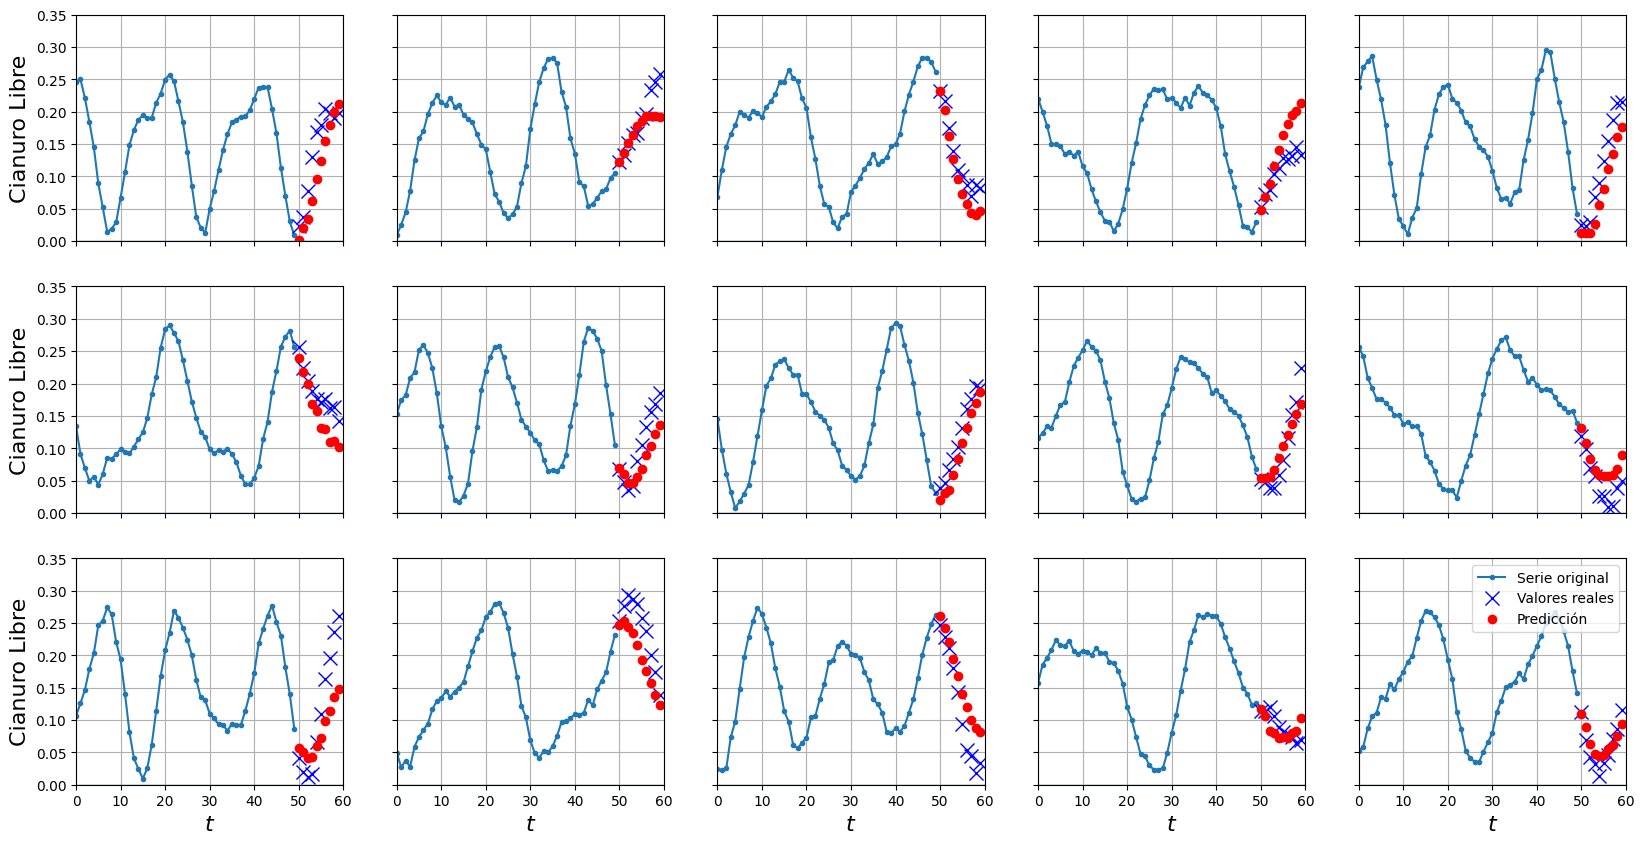

Mean Squared Error (MSE) para el modelo GRU: 0.0016112407902255654


In [ ]:
# Realizar predicciones con el modelo GRU entrenado sobre los datos de prueba
y_pred_gru = predict(gru, dataloader['test'])

# Graficar la serie temporal real y las predicciones generadas por GRU
plot_series(X_test, Y_test[:,-1], y_pred_gru[:,-1].cpu().numpy())

# Calcular el error cuadrático medio (MSE) para las predicciones
mse_gru = mean_squared_error(Y_test[:,-1], y_pred_gru[:,-1].cpu())
print(f"Mean Squared Error (MSE) para el modelo GRU: {mse_gru}")

## Observaciones

-LAS MÉTRICAS OBTENIDAS PARA LAS DIFERENTES PREDICCIONES SON:

1. CELDA RECURRENTE:  0.001422

2. LSTM: 0.001044

3. GATED RECURRENT UNIT: 0.001611

CONCLUSIÓN: La mejor métrica se obtiene con LSTM.
